### Import all the requirements

In [1]:
import pandas as pd
import numpy as np
from openpyxl import load_workbook
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
pd.set_option('display.max_rows', 100)

# Step A: Data Gathering

### StepA.1: Aggregate the sales data from multiple excel sheets

In [2]:
txtfiles = []

# Intention: Iterate over all the excel files in the sales data folder & create a combined dataframe
overall_sales_data_df = None
for make_level_sales_file in glob.glob("./sales-data/*.xlsx"):
    sales_data_dict = {}
    sales_data_df =None
    sheets = load_workbook(make_level_sales_file, read_only=True).sheetnames
    print(make_level_sales_file)
    # Step 1A: Iterate over all the sheets to get year-wise data for the make example: Hyundau - 2022, 2021 etc data
    for sheet in sheets:
        sales_data_dict[sheet] = pd.read_excel(open(make_level_sales_file,'rb'), sheet_name=sheet)
        if sales_data_df is None:
            sales_data_df = sales_data_dict[sheet]
        else:
            sales_data_df = pd.merge(sales_data_df, sales_data_dict[sheet], on=["Maker/Brand", "Group", "Type", "Model","Segment"])
    # Step 1B: Add this make level df to the overall sales df
    if overall_sales_data_df is None:
        overall_sales_data_df = sales_data_df
    else:
        overall_sales_data_df = pd.concat([overall_sales_data_df,sales_data_df])
    

./sales-data/Honda_dataset.xlsx
./sales-data/Datsun_dataset.xlsx
./sales-data/Suzuki_dataset.xlsx
./sales-data/Mahindra_dataset.xlsx
./sales-data/Skoda_dataset.xlsx
./sales-data/VW_dataset.xlsx
./sales-data/Tata_dataset.xlsx
./sales-data/Hyundai_dataset.xlsx
./sales-data/Toyota_dataset.xlsx
./sales-data/Renault_dataset.xlsx


In [3]:
overall_sales_data_df

,Group,Maker/Brand,Type,Segment,Model,2022-01-01 00:00:00,2022-02-01 00:00:00,2022-03-01 00:00:00,2022-04-01 00:00:00,2022-05-01 00:00:00,...,2017-03-01 00:00:00,2017-04-01 00:00:00,2017-05-01 00:00:00,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00
0,Honda,Honda,Cars,A,Amaze,5295.0,3485.0,3406.0,-,-,...,1667.0,1031.0,775.0,1014.0,1379.0,1980.0,2989.0,1062.0,1152.0,1685.0
1,Honda,Honda,Cars,B,Fit (Jazz),420.0,420.0,120.0,-,-,...,3013.0,642.0,951.0,1079.0,3418.0,2334.0,2947.0,2879.0,2220.0,1924.0
2,Honda,Honda,Cars,C,City,5638.0,4468.0,5824.0,-,-,...,6424.0,5873.0,4183.0,4999.0,4687.0,5614.0,6559.0,4864.0,4439.0,5041.0
3,Honda,Honda,UVs/MPVs,SUV-B,WR-V,510.0,510.0,390.0,-,-,...,1680.0,3294.0,2824.0,4323.0,4874.0,5201.0,4877.0,3344.0,3611.0,5211.0
0,Renault-Nissan Alliance,Datsun,Cars,A,Redi-GO,NaN,NaN,NaN,NaN,NaN,...,1551.0,1981.0,1977.0,2791.0,2474.0,3042.0,2514.0,2339.0,3001.0,2298.0
1,Renault-Nissan Alliance,Datsun,Cars,B,Go,NaN,NaN,NaN,NaN,NaN,...,1072.0,1309.0,1288.0,1696.0,745.0,1069.0,770.0,646.0,1025.0,858.0
2,Renault-Nissan Alliance,Datsun,UVs/MPVs,MPV,Go+,NaN,NaN,NaN,NaN,NaN,...,624.0,1011.0,767.0,1147.0,544.0,586.0,317.0,478.0,380.0,499.0
0,Suzuki,Suzuki,Cars,A,Alto,13079.0,12123.0,8022.0,-,-,...,23437.0,20664.0,25610.0,18558.0,24665.0,24558.0,23085.0,21438.0,25146.0,20615.0
1,Suzuki,Suzuki,Cars,A,Celerio,10585.0,10531.0,8483.0,-,-,...,9856.0,7713.0,8470.0,8291.0,10576.0,10360.0,9451.0,9134.0,8641.0,6102.0
2,Suzuki,Suzuki,Cars,A,Wagon R,20457.0,21038.0,18527.0,-,-,...,15067.0,14048.0,16059.0,11415.0,14566.0,14670.0,13993.0,13053.0,13969.0,11803.0


### Step A.2: Popularity Index Calculation Based on the Sales Data

In [4]:
# Step 2.A: Using melt transposed the data to get Monthly level sales at Make-Model-Month level
overall_sales_data_df = overall_sales_data_df.melt(id_vars=["Group", "Maker/Brand","Type","Segment","Model"], 
        var_name="Month", 
        value_name="Sales")

In [5]:
# Step 2.B Remove Not Numeric records from Sales Data
overall_sales_data_df["Sales"] = overall_sales_data_df["Sales"].apply(lambda s: pd.to_numeric(s, errors='coerce'))
overall_sales_data_df = overall_sales_data_df[overall_sales_data_df["Sales"].notna()]

In [6]:
# Step 2.C: Create Monthly Segment Sales
overall_sales_data_df["Monthly_Segment_Sales"] = overall_sales_data_df["Sales"].groupby([overall_sales_data_df["Month"],overall_sales_data_df["Segment"]]).transform('sum')
overall_sales_data_df["Percentage_Contribution"] = (overall_sales_data_df["Sales"] /overall_sales_data_df["Monthly_Segment_Sales"])*100


In [7]:
overall_sales_data_df["Percentage_Contribution"]

0        8.219880
1        0.805833
2       21.143821
3        1.757166
7       20.303647
          ...    
3091     1.104939
3092     0.000000
3093    34.930579
3094    39.026801
3095     9.468848
Name: Percentage_Contribution, Length: 2685, dtype: float64

<AxesSubplot:>

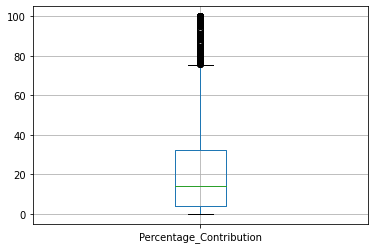

In [8]:
overall_sales_data_df.boxplot(column='Percentage_Contribution', return_type='axes')

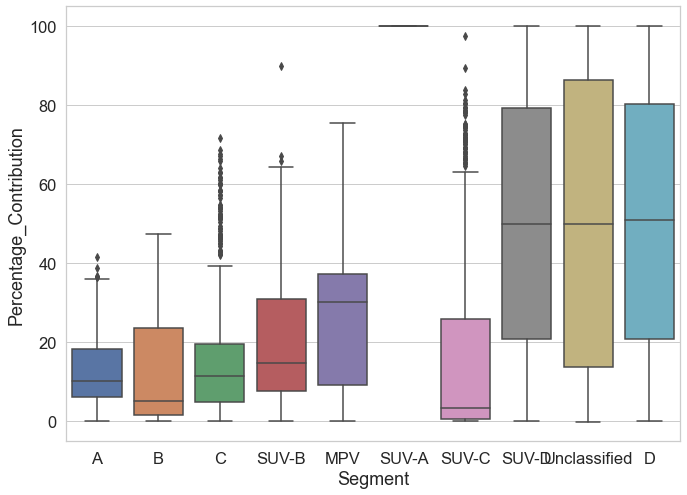

In [9]:
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')

sns.boxplot(x="Segment", y="Percentage_Contribution", data=overall_sales_data_df);

### Step A.3: Get the features & price data

In [10]:
features_df = pd.read_csv('./features-data/cars_ds_final.csv')

In [11]:
# sample data preview
features_df.head(5)

,Unnamed: 0,Make,Model,Variant,Ex-Showroom_Price,Displacement,Cylinders,Valves_Per_Cylinder,Drivetrain,Cylinder_Configuration,...,Leather_Wrapped_Steering,Automatic_Headlamps,Engine_Type,ASR_/_Traction_Control,Cruise_Control,USB_Ports,Heads-Up_Display,Welcome_Lights,Battery,Electric_Range
0,0,Tata,Nano Genx,Xt,"Rs. 2,92,667",624 cc,2.0,2.0,RWD (Rear Wheel Drive),In-line,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Tata,Nano Genx,Xe,"Rs. 2,36,447",624 cc,2.0,2.0,RWD (Rear Wheel Drive),In-line,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Tata,Nano Genx,Emax Xm,"Rs. 2,96,661",624 cc,2.0,2.0,RWD (Rear Wheel Drive),In-line,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Tata,Nano Genx,Xta,"Rs. 3,34,768",624 cc,2.0,2.0,RWD (Rear Wheel Drive),In-line,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Tata,Nano Genx,Xm,"Rs. 2,72,223",624 cc,2.0,2.0,RWD (Rear Wheel Drive),In-line,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#shape of the featues data
features_df.shape

(1276, 141)

In [13]:
#information of the car features data
features_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1276 entries, 0 to 1275
Data columns (total 141 columns):
 #    Column                                     Dtype  
---   ------                                     -----  
 0    Unnamed: 0                                 int64  
 1    Make                                       object 
 2    Model                                      object 
 3    Variant                                    object 
 4    Ex-Showroom_Price                          object 
 5    Displacement                               object 
 6    Cylinders                                  float64
 7    Valves_Per_Cylinder                        float64
 8    Drivetrain                                 object 
 9    Cylinder_Configuration                     object 
 10   Emission_Norm                              object 
 11   Engine_Location                            object 
 12   Fuel_System                                object 
 13   Fuel_Tank_Capacity             

In [14]:
# All the columns of Car Featues
features_df.columns.tolist()

['Unnamed: 0',
 'Make',
 'Model',
 'Variant',
 'Ex-Showroom_Price',
 'Displacement',
 'Cylinders',
 'Valves_Per_Cylinder',
 'Drivetrain',
 'Cylinder_Configuration',
 'Emission_Norm',
 'Engine_Location',
 'Fuel_System',
 'Fuel_Tank_Capacity',
 'Fuel_Type',
 'Height',
 'Length',
 'Width',
 'Body_Type',
 'Doors',
 'City_Mileage',
 'Highway_Mileage',
 'ARAI_Certified_Mileage',
 'ARAI_Certified_Mileage_for_CNG',
 'Kerb_Weight',
 'Gears',
 'Ground_Clearance',
 'Front_Brakes',
 'Rear_Brakes',
 'Front_Suspension',
 'Rear_Suspension',
 'Front_Track',
 'Rear_Track',
 'Front_Tyre_&_Rim',
 'Rear_Tyre_&_Rim',
 'Power_Steering',
 'Power_Windows',
 'Power_Seats',
 'Keyless_Entry',
 'Power',
 'Torque',
 'Odometer',
 'Speedometer',
 'Tachometer',
 'Tripmeter',
 'Seating_Capacity',
 'Seats_Material',
 'Type',
 'Wheelbase',
 'Wheels_Size',
 'Start_/_Stop_Button',
 '12v_Power_Outlet',
 'Audiosystem',
 'Aux-in_Compatibility',
 'Average_Fuel_Consumption',
 'Basic_Warranty',
 'Bluetooth',
 'Boot-lid_Opener',

In [15]:
# Description of the Features data
features_df.describe()

,Unnamed: 0,Cylinders,Valves_Per_Cylinder,Doors,Seating_Capacity,Number_of_Airbags,USB_Ports
count,1276.000000,1210.000000,1174.000000,1272.000000,1270.000000,1141.000000,29.000000
mean,637.500000,4.380992,3.977853,4.550314,5.270079,3.787029,1.793103
std,368.493781,1.660957,0.833763,0.747816,1.145231,2.522399,0.773642
min,0.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000
25%,318.750000,4.000000,4.000000,4.000000,5.000000,2.000000,1.000000
50%,637.500000,4.000000,4.000000,5.000000,5.000000,2.000000,2.000000
75%,956.250000,4.000000,4.000000,5.000000,5.000000,6.000000,2.000000
max,1275.000000,16.000000,16.000000,5.000000,16.000000,14.000000,3.000000


# Step B: Data Cleaning

### Step B.1: Cleaning Features + Price Data (At Make, Model and Varient Level)

In [16]:
# Dropping the Unamed columns as it is simply as index

features_df = features_df.drop('Unnamed: 0',axis=1)

In [17]:
# Dropping City_Mileage, Highway_Mileage and ARAI_Certified_Mileage_for_CNG as we are keeping ARAI_Certified_Mileage
features_df = features_df.drop(['City_Mileage','Highway_Mileage','ARAI_Certified_Mileage_for_CNG','Average_Fuel_Consumption'],axis=1)

In [18]:
# Dropping other specs
features_df = features_df.drop(['Tripmeter',"Other_Specs","Other_specs"],axis=1)

In [19]:
# Correcting minor issues in the csv files to get the current datatype
features_df['Ex-Showroom_Price'] = features_df['Ex-Showroom_Price'].str.replace('Rs. ','')
features_df['Ex-Showroom_Price'] = features_df['Ex-Showroom_Price'].str.replace(',','')
features_df['Ex-Showroom_Price'] = features_df['Ex-Showroom_Price'].astype(int)
features_df = features_df[~features_df.ARAI_Certified_Mileage.isnull()]
features_df = features_df[~features_df.Make.isnull()]
features_df = features_df[~features_df.Width.isnull()]
features_df = features_df[~features_df.Cylinders.isnull()]
features_df = features_df[~features_df.Wheelbase.isnull()]
features_df = features_df[~features_df['Fuel_Tank_Capacity'].isnull()]
features_df = features_df[~features_df['Seating_Capacity'].isnull()]
features_df = features_df[~features_df['Torque'].isnull()]
features_df['Height'] = features_df['Height'].str.replace(' mm','').astype(float)
features_df['Length'] = features_df['Length'].str.replace(' mm','').astype(float)
features_df['Width'] = features_df['Width'].str.replace(' mm','').astype(float)
features_df['Wheelbase'] = features_df['Wheelbase'].str.replace(' mm','').astype(float)
features_df['Fuel_Tank_Capacity'] = features_df['Fuel_Tank_Capacity'].str.replace(' litres','').astype(float)
features_df['Displacement'] = features_df['Displacement'].str.replace(' cc','')
features_df.loc[features_df.ARAI_Certified_Mileage == '9.8-10.0 km/litre','ARAI_Certified_Mileage'] = '10'
features_df.loc[features_df.ARAI_Certified_Mileage == '10kmpl km/litre','ARAI_Certified_Mileage'] = '10'
features_df['ARAI_Certified_Mileage'] = features_df['ARAI_Certified_Mileage'].str.replace(' km/litre','').astype(float)
features_df.Number_of_Airbags.fillna(0,inplace= True)
features_df['price'] = features_df['Ex-Showroom_Price']
features_df.drop(columns='Ex-Showroom_Price', inplace= True)
features_df.price = features_df.price.astype(int)
HP = features_df.Power.str.extract(r'(\d{1,4}).*').astype(int) * 0.98632
HP = HP.apply(lambda x: round(x,2))
TQ = features_df.Torque.str.extract(r'(\d{1,4}).*').astype(int)
TQ = TQ.apply(lambda x: round(x,2))
features_df.Torque = TQ
features_df.Power = HP
features_df.Doors = features_df.Doors.astype(int)
features_df.Seating_Capacity = features_df.Seating_Capacity.astype(int)
features_df.Number_of_Airbags = features_df.Number_of_Airbags.astype(int)
features_df.Displacement = features_df.Displacement.astype(int)
features_df.Cylinders = features_df.Cylinders.astype(int)
features_df["Kerb_Weight"] = features_df["Kerb_Weight"].str.replace(' kg','')
features_df["Kerb_Weight"] = features_df["Kerb_Weight"].apply(pd.to_numeric, errors='coerce').fillna(0)
features_df["Ground_Clearance"] = features_df["Ground_Clearance"].str.replace(' mm','')
features_df["Ground_Clearance"] = features_df["Ground_Clearance"].apply(pd.to_numeric, errors='coerce').fillna(0)
features_df["Front_Track"] = features_df["Front_Track"].str.replace(' mm','')
features_df["Front_Track"] = features_df["Front_Track"].apply(pd.to_numeric, errors='coerce').fillna(0)
features_df["Rear_Track"] = features_df["Rear_Track"].str.replace(' mm','')
features_df["Rear_Track"] = features_df["Rear_Track"].apply(pd.to_numeric, errors='coerce').fillna(0)
features_df["Minimum_Turning_Radius"] = features_df["Minimum_Turning_Radius"].str.replace(' meter','')
features_df["Minimum_Turning_Radius"] = features_df["Minimum_Turning_Radius"].apply(pd.to_numeric, errors='coerce').fillna(0)
features_df["Gross_Vehicle_Weight"] = features_df["Gross_Vehicle_Weight"].str.replace(' kg','')
features_df["Gross_Vehicle_Weight"] = features_df["Gross_Vehicle_Weight"].apply(pd.to_numeric, errors='coerce').fillna(0)


/var/folders/s0/w17scwd1277ff63dz232pg940000gp/T/ipykernel_6212/1642787549.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  features_df['Ex-Showroom_Price'] = features_df['Ex-Showroom_Price'].str.replace('Rs. ','')


In [20]:
# Get info to check columns datatypes
features_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 987 entries, 0 to 1275
Data columns (total 133 columns):
 #    Column                                     Dtype  
---   ------                                     -----  
 0    Make                                       object 
 1    Model                                      object 
 2    Variant                                    object 
 3    Displacement                               int64  
 4    Cylinders                                  int64  
 5    Valves_Per_Cylinder                        float64
 6    Drivetrain                                 object 
 7    Cylinder_Configuration                     object 
 8    Emission_Norm                              object 
 9    Engine_Location                            object 
 10   Fuel_System                                object 
 11   Fuel_Tank_Capacity                         float64
 12   Fuel_Type                                  object 
 13   Height                          

In [21]:
# Handle all NaN value - BIUFC stands for boolean, signed integer, 
# unsigned integer, floating-point, complex floating-point

features_df = features_df.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' else x.fillna('No'))

In [22]:
features_df

,Make,Model,Variant,Displacement,Cylinders,Valves_Per_Cylinder,Drivetrain,Cylinder_Configuration,Emission_Norm,Engine_Location,...,Automatic_Headlamps,Engine_Type,ASR_/_Traction_Control,Cruise_Control,USB_Ports,Heads-Up_Display,Welcome_Lights,Battery,Electric_Range,price
0,Tata,Nano Genx,Xt,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,No,No,No,No,0.0,No,No,No,No,292667
1,Tata,Nano Genx,Xe,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,No,No,No,No,0.0,No,No,No,No,236447
3,Tata,Nano Genx,Xta,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,No,No,No,No,0.0,No,No,No,No,334768
4,Tata,Nano Genx,Xm,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,No,No,No,No,0.0,No,No,No,No,272223
5,Tata,Nano Genx,Xma,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,No,No,No,No,0.0,No,No,No,No,314815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271,Honda,City,Vx Mt Diesel,1498,4,4.0,FWD (Front Wheel Drive),In-line,BS IV,"Front, Transverse",...,No,No,No,Yes,0.0,No,No,No,No,1302000
1272,Honda,City,Zx Mt Diesel,1498,4,4.0,FWD (Front Wheel Drive),In-line,BS IV,"Front, Transverse",...,Yes,No,No,Yes,0.0,No,No,No,No,1421000
1273,Honda,City,Zx Cvt Petrol,1497,4,4.0,FWD (Front Wheel Drive),In-line,BS 6,"Front, Transverse",...,Yes,No,No,Yes,0.0,No,No,No,No,1431000
1274,Honda,City,V Cvt Petrol,1497,4,4.0,FWD (Front Wheel Drive),In-line,BS 6,"Front, Transverse",...,No,No,No,Yes,0.0,No,No,No,No,1201000


In [23]:
# Final info for the Features + Price data
features_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 987 entries, 0 to 1275
Data columns (total 133 columns):
 #    Column                                     Dtype  
---   ------                                     -----  
 0    Make                                       object 
 1    Model                                      object 
 2    Variant                                    object 
 3    Displacement                               int64  
 4    Cylinders                                  int64  
 5    Valves_Per_Cylinder                        float64
 6    Drivetrain                                 object 
 7    Cylinder_Configuration                     object 
 8    Emission_Norm                              object 
 9    Engine_Location                            object 
 10   Fuel_System                                object 
 11   Fuel_Tank_Capacity                         float64
 12   Fuel_Type                                  object 
 13   Height                          

### Step B.2 Cleaning the Sales Data

In [24]:
## Get the info of the sales data
overall_sales_data_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2685 entries, 0 to 3095
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Group                    2685 non-null   object        
 1   Maker/Brand              2685 non-null   object        
 2   Type                     2685 non-null   object        
 3   Segment                  2685 non-null   object        
 4   Model                    2685 non-null   object        
 5   Month                    2685 non-null   datetime64[ns]
 6   Sales                    2685 non-null   float64       
 7   Monthly_Segment_Sales    2685 non-null   float64       
 8   Percentage_Contribution  2641 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 209.8+ KB


In [25]:
# Rename column containing slash (/) - We prefeer columns to have underscore
overall_sales_data_df["Make"] = overall_sales_data_df["Maker/Brand"]
overall_sales_data_df.drop(columns='Maker/Brand', inplace= True)

# Step C: Data Preparation

Merge both the sales data and features + price data together

In [26]:
# Inner merge to keep the common data only
complete_data_df = overall_sales_data_df.merge(features_df,how='inner',\
                            left_on=['Make','Model'],\
                            right_on=['Make',"Model"])


In [27]:
# Get the info
complete_data_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6381 entries, 0 to 6380
Data columns (total 140 columns):
 #    Column                                     Dtype         
---   ------                                     -----         
 0    Group                                      object        
 1    Type_x                                     object        
 2    Segment                                    object        
 3    Model                                      object        
 4    Month                                      datetime64[ns]
 5    Sales                                      float64       
 6    Monthly_Segment_Sales                      float64       
 7    Percentage_Contribution                    float64       
 8    Make                                       object        
 9    Variant                                    object        
 10   Displacement                               int64         
 11   Cylinders                                  int64      

In [28]:
# Get the shape
complete_data_df.shape

(6381, 140)

In [29]:
# Get the Models which are covered after the merge
complete_data_df["Model"].unique()

array(['Amaze', 'City', 'Kodiaq', 'Tiago', 'Tigor', 'Nexon', 'Xcent',
       'Camry', 'Fortuner', 'Kwid', 'Go'], dtype=object)

# Step D: Data Visualization

## Step D.1 : Features Data

In [30]:
# Checking for outliers
plt.figure(figsize=(40,80), dpi=200)
index = 1
for column in features_df.columns.values:
    if features_df[column].dtype.kind in 'biufc':
        plt.subplot(10,3,index)
        index +=1
        sns.boxplot(x = column, data = features_df)
    

In [31]:
# checking for outliers using the Z-score

numeric_columns = []
for column in features_df.columns.values:
    if features_df[column].dtype.kind in 'biufc':
        numeric_columns.append(column)
z = np.abs(stats.zscore(features_df[numeric_columns]))

# Decide the THRESHOLD on the basis of count of the dropping records
THRESHOLD = 4
old_records = features_df.shape
dropping_records = z[(z > THRESHOLD).any(1)].shape

print(f"Dropping {dropping_records[0]} from {old_records[0]} entries")
print(f"Making total entries as {old_records[0]-dropping_records[0]}")

Dropping 64 from 987 entries
Making total entries as 923


In [32]:
# Drop the records
features_df_outliers_removed = features_df[(z<THRESHOLD).all(axis=1)]
features_df_outliers_removed.shape

(923, 133)

In [33]:
features_df_outliers_removed


,Make,Model,Variant,Displacement,Cylinders,Valves_Per_Cylinder,Drivetrain,Cylinder_Configuration,Emission_Norm,Engine_Location,...,Automatic_Headlamps,Engine_Type,ASR_/_Traction_Control,Cruise_Control,USB_Ports,Heads-Up_Display,Welcome_Lights,Battery,Electric_Range,price
0,Tata,Nano Genx,Xt,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,No,No,No,No,0.0,No,No,No,No,292667
1,Tata,Nano Genx,Xe,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,No,No,No,No,0.0,No,No,No,No,236447
3,Tata,Nano Genx,Xta,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,No,No,No,No,0.0,No,No,No,No,334768
4,Tata,Nano Genx,Xm,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,No,No,No,No,0.0,No,No,No,No,272223
5,Tata,Nano Genx,Xma,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,No,No,No,No,0.0,No,No,No,No,314815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271,Honda,City,Vx Mt Diesel,1498,4,4.0,FWD (Front Wheel Drive),In-line,BS IV,"Front, Transverse",...,No,No,No,Yes,0.0,No,No,No,No,1302000
1272,Honda,City,Zx Mt Diesel,1498,4,4.0,FWD (Front Wheel Drive),In-line,BS IV,"Front, Transverse",...,Yes,No,No,Yes,0.0,No,No,No,No,1421000
1273,Honda,City,Zx Cvt Petrol,1497,4,4.0,FWD (Front Wheel Drive),In-line,BS 6,"Front, Transverse",...,Yes,No,No,Yes,0.0,No,No,No,No,1431000
1274,Honda,City,V Cvt Petrol,1497,4,4.0,FWD (Front Wheel Drive),In-line,BS 6,"Front, Transverse",...,No,No,No,Yes,0.0,No,No,No,No,1201000


# Step E: Cluster Creation

## Step E.1: Converting the string data into numeric 

In [34]:
features_df_outliers_removed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 923 entries, 0 to 1275
Columns: 133 entries, Make to price
dtypes: float64(15), int64(7), object(111)
memory usage: 966.3+ KB


In [35]:
X = features_df_outliers_removed.drop(['Make','Model','Variant'],axis =1)  
Y = features_df_outliers_removed[['Make','Model','Variant']]

In [36]:
## Standardize the object categorical data so that it can be used
from sklearn.preprocessing import LabelEncoder
# Creating a instance of label Encoder.
le = LabelEncoder()
X_copy = X
for column in X_copy.columns.values:
    if not (X_copy[column].dtype.kind in 'biufc'):
        label = le.fit_transform(X[column])
        X.drop(column, axis=1, inplace=True)
        X[column]=label     

## Step E.2 Principal Component Analysis 

In [37]:
X.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 923 entries, 0 to 1275
Data columns (total 130 columns):
 #    Column                                     Dtype  
---   ------                                     -----  
 0    Displacement                               int64  
 1    Cylinders                                  int64  
 2    Valves_Per_Cylinder                        float64
 3    Fuel_Tank_Capacity                         float64
 4    Height                                     float64
 5    Length                                     float64
 6    Width                                      float64
 7    Doors                                      int64  
 8    ARAI_Certified_Mileage                     float64
 9    Kerb_Weight                                float64
 10   Ground_Clearance                           float64
 11   Front_Track                                float64
 12   Rear_Track                                 float64
 13   Power                           

In [38]:
## Shapes of X & Y. Y contains the Make Model Varient which we are keeping separately
X.shape
Y.shape

(923, 3)

In [39]:
X.head(2)

,Displacement,Cylinders,Valves_Per_Cylinder,Fuel_Tank_Capacity,Height,Length,Width,Doors,ARAI_Certified_Mileage,Kerb_Weight,...,Paddle_Shifters,Leather_Wrapped_Steering,Automatic_Headlamps,Engine_Type,ASR_/_Traction_Control,Cruise_Control,Heads-Up_Display,Welcome_Lights,Battery,Electric_Range
0,624,2,2.0,24.0,1652.0,3164.0,1750.0,5,23.6,660.0,...,0,0,0,2,0,0,0,0,0,0
1,624,2,2.0,24.0,1652.0,3164.0,1750.0,5,23.6,725.0,...,0,0,0,2,0,0,0,0,0,0


In [40]:
Y.head(2)

,Make,Model,Variant
0,Tata,Nano Genx,Xt
1,Tata,Nano Genx,Xe


In [41]:
# Standardization of the dataset before performing PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [42]:
# Dataframe of Standardized Scaled version of X
X_scaled_df = pd.DataFrame(X_scaled,columns=X.columns)
X_scaled_df.head(5)

,Displacement,Cylinders,Valves_Per_Cylinder,Fuel_Tank_Capacity,Height,Length,Width,Doors,ARAI_Certified_Mileage,Kerb_Weight,...,Paddle_Shifters,Leather_Wrapped_Steering,Automatic_Headlamps,Engine_Type,ASR_/_Traction_Control,Cruise_Control,Heads-Up_Display,Welcome_Lights,Battery,Electric_Range
0,-1.55814,-2.31435,-2.019523,-1.834955,0.41098,-2.596421,-0.151532,0.595921,1.113346,-0.469317,...,-0.424626,-0.827228,-0.704236,-0.029786,-0.59946,-0.738961,-0.128529,-0.170251,0.0,0.0
1,-1.55814,-2.31435,-2.019523,-1.834955,0.41098,-2.596421,-0.151532,0.595921,1.113346,-0.371394,...,-0.424626,-0.827228,-0.704236,-0.029786,-0.59946,-0.738961,-0.128529,-0.170251,0.0,0.0
2,-1.55814,-2.31435,-2.019523,-1.834955,0.41098,-2.596421,-0.151532,0.595921,0.710429,-0.371394,...,-0.424626,-0.827228,-0.704236,-0.029786,-0.59946,-0.738961,-0.128529,-0.170251,0.0,0.0
3,-1.55814,-2.31435,-2.019523,-1.834955,0.41098,-2.596421,-0.151532,0.595921,1.113346,-0.371394,...,-0.424626,-0.827228,-0.704236,-0.029786,-0.59946,-0.738961,-0.128529,-0.170251,0.0,0.0
4,-1.55814,-2.31435,-2.019523,-1.834955,0.41098,-2.596421,-0.151532,0.595921,0.710429,-0.393992,...,-0.424626,-0.827228,-0.704236,-0.029786,-0.59946,-0.738961,-0.128529,-0.170251,0.0,0.0


<AxesSubplot:>

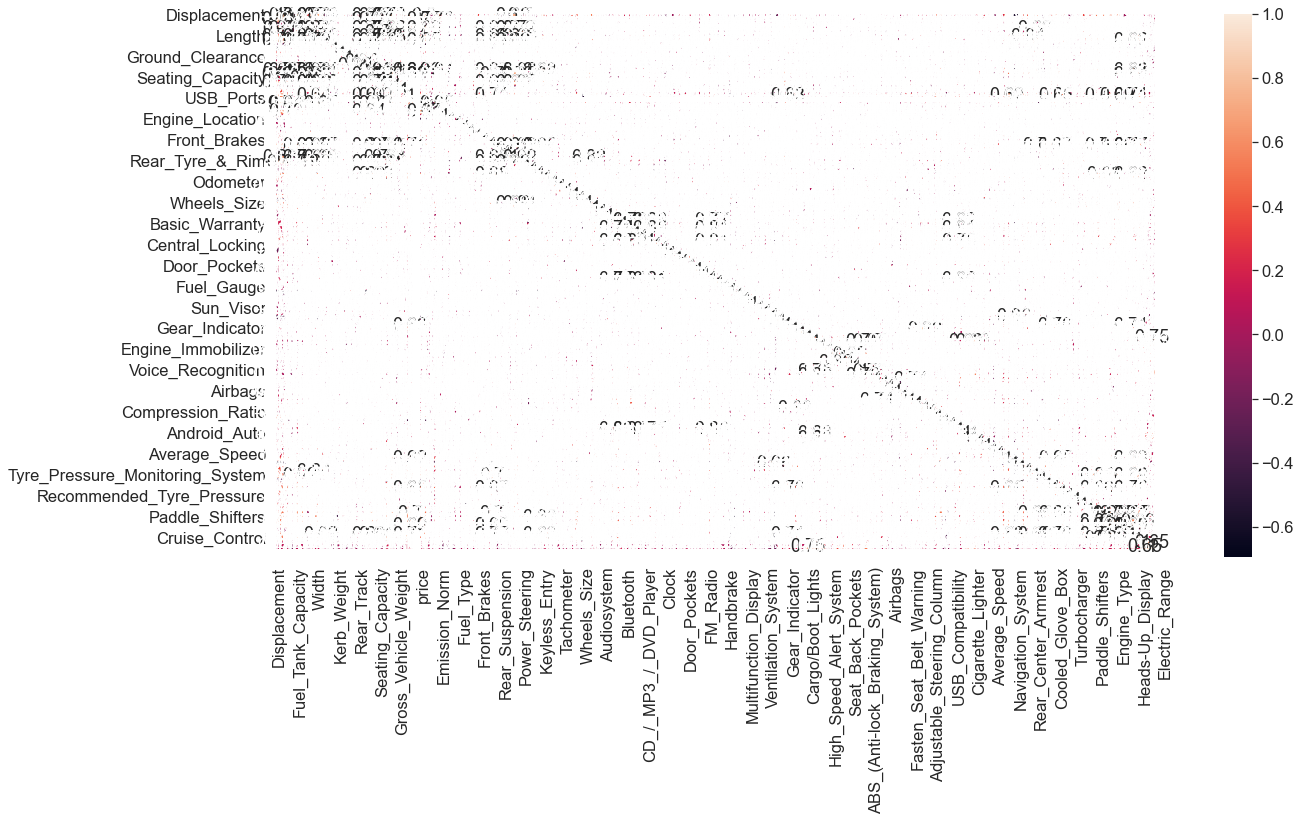

In [43]:
# The correlation matrix 
plt.figure(figsize = (20,10))       
sns.heatmap(X_scaled_df.corr(),annot = True)

In [44]:
from sklearn.decomposition import PCA
pca = PCA(random_state=42)
pca.fit(X_scaled)
pca.components_[0]
pca.explained_variance_ratio_

array([2.02403420e-01, 6.72796162e-02, 5.33402607e-02, 3.49870591e-02,
       3.28420820e-02, 2.61187427e-02, 2.22863988e-02, 2.16971259e-02,
       1.90361878e-02, 1.87554567e-02, 1.69296226e-02, 1.57640589e-02,
       1.52869356e-02, 1.38412005e-02, 1.30378543e-02, 1.25883877e-02,
       1.22740714e-02, 1.17850067e-02, 1.14227711e-02, 1.11924928e-02,
       1.08516730e-02, 1.05835661e-02, 9.83742519e-03, 9.68823896e-03,
       9.61106203e-03, 9.31369453e-03, 9.02983301e-03, 8.66880977e-03,
       8.53673479e-03, 8.14486791e-03, 7.93936133e-03, 7.89423728e-03,
       7.58250420e-03, 7.31746165e-03, 7.14835443e-03, 6.97240474e-03,
       6.88455664e-03, 6.49972911e-03, 6.33577510e-03, 6.26175996e-03,
       6.10212253e-03, 5.87999790e-03, 5.79225803e-03, 5.70159416e-03,
       5.51986480e-03, 5.39131681e-03, 5.35325389e-03, 5.10407534e-03,
       4.89747634e-03, 4.68536001e-03, 4.55609055e-03, 4.42280526e-03,
       4.36986322e-03, 4.22973272e-03, 4.12179635e-03, 3.98890478e-03,
      

In [45]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)
var_cumu

array([0.20240342, 0.26968304, 0.3230233 , 0.35801036, 0.39085244,
       0.41697118, 0.43925758, 0.46095471, 0.47999089, 0.49874635,
       0.51567597, 0.53144003, 0.54672697, 0.56056817, 0.57360602,
       0.58619441, 0.59846848, 0.61025349, 0.62167626, 0.63286875,
       0.64372042, 0.65430399, 0.66414142, 0.67382966, 0.68344072,
       0.69275441, 0.70178424, 0.71045305, 0.71898979, 0.72713466,
       0.73507402, 0.74296826, 0.75055076, 0.75786822, 0.76501658,
       0.77198898, 0.77887354, 0.78537327, 0.79170904, 0.7979708 ,
       0.80407292, 0.80995292, 0.81574518, 0.82144677, 0.82696664,
       0.83235796, 0.83771121, 0.84281529, 0.84771276, 0.85239812,
       0.85695421, 0.86137702, 0.86574688, 0.86997661, 0.87409841,
       0.87808731, 0.88203139, 0.88593638, 0.8896926 , 0.89336652,
       0.89689723, 0.90030414, 0.90365432, 0.90688039, 0.91008752,
       0.91325056, 0.91631655, 0.9193313 , 0.92225681, 0.92513614,
       0.92791579, 0.93066928, 0.9333642 , 0.93597699, 0.93849

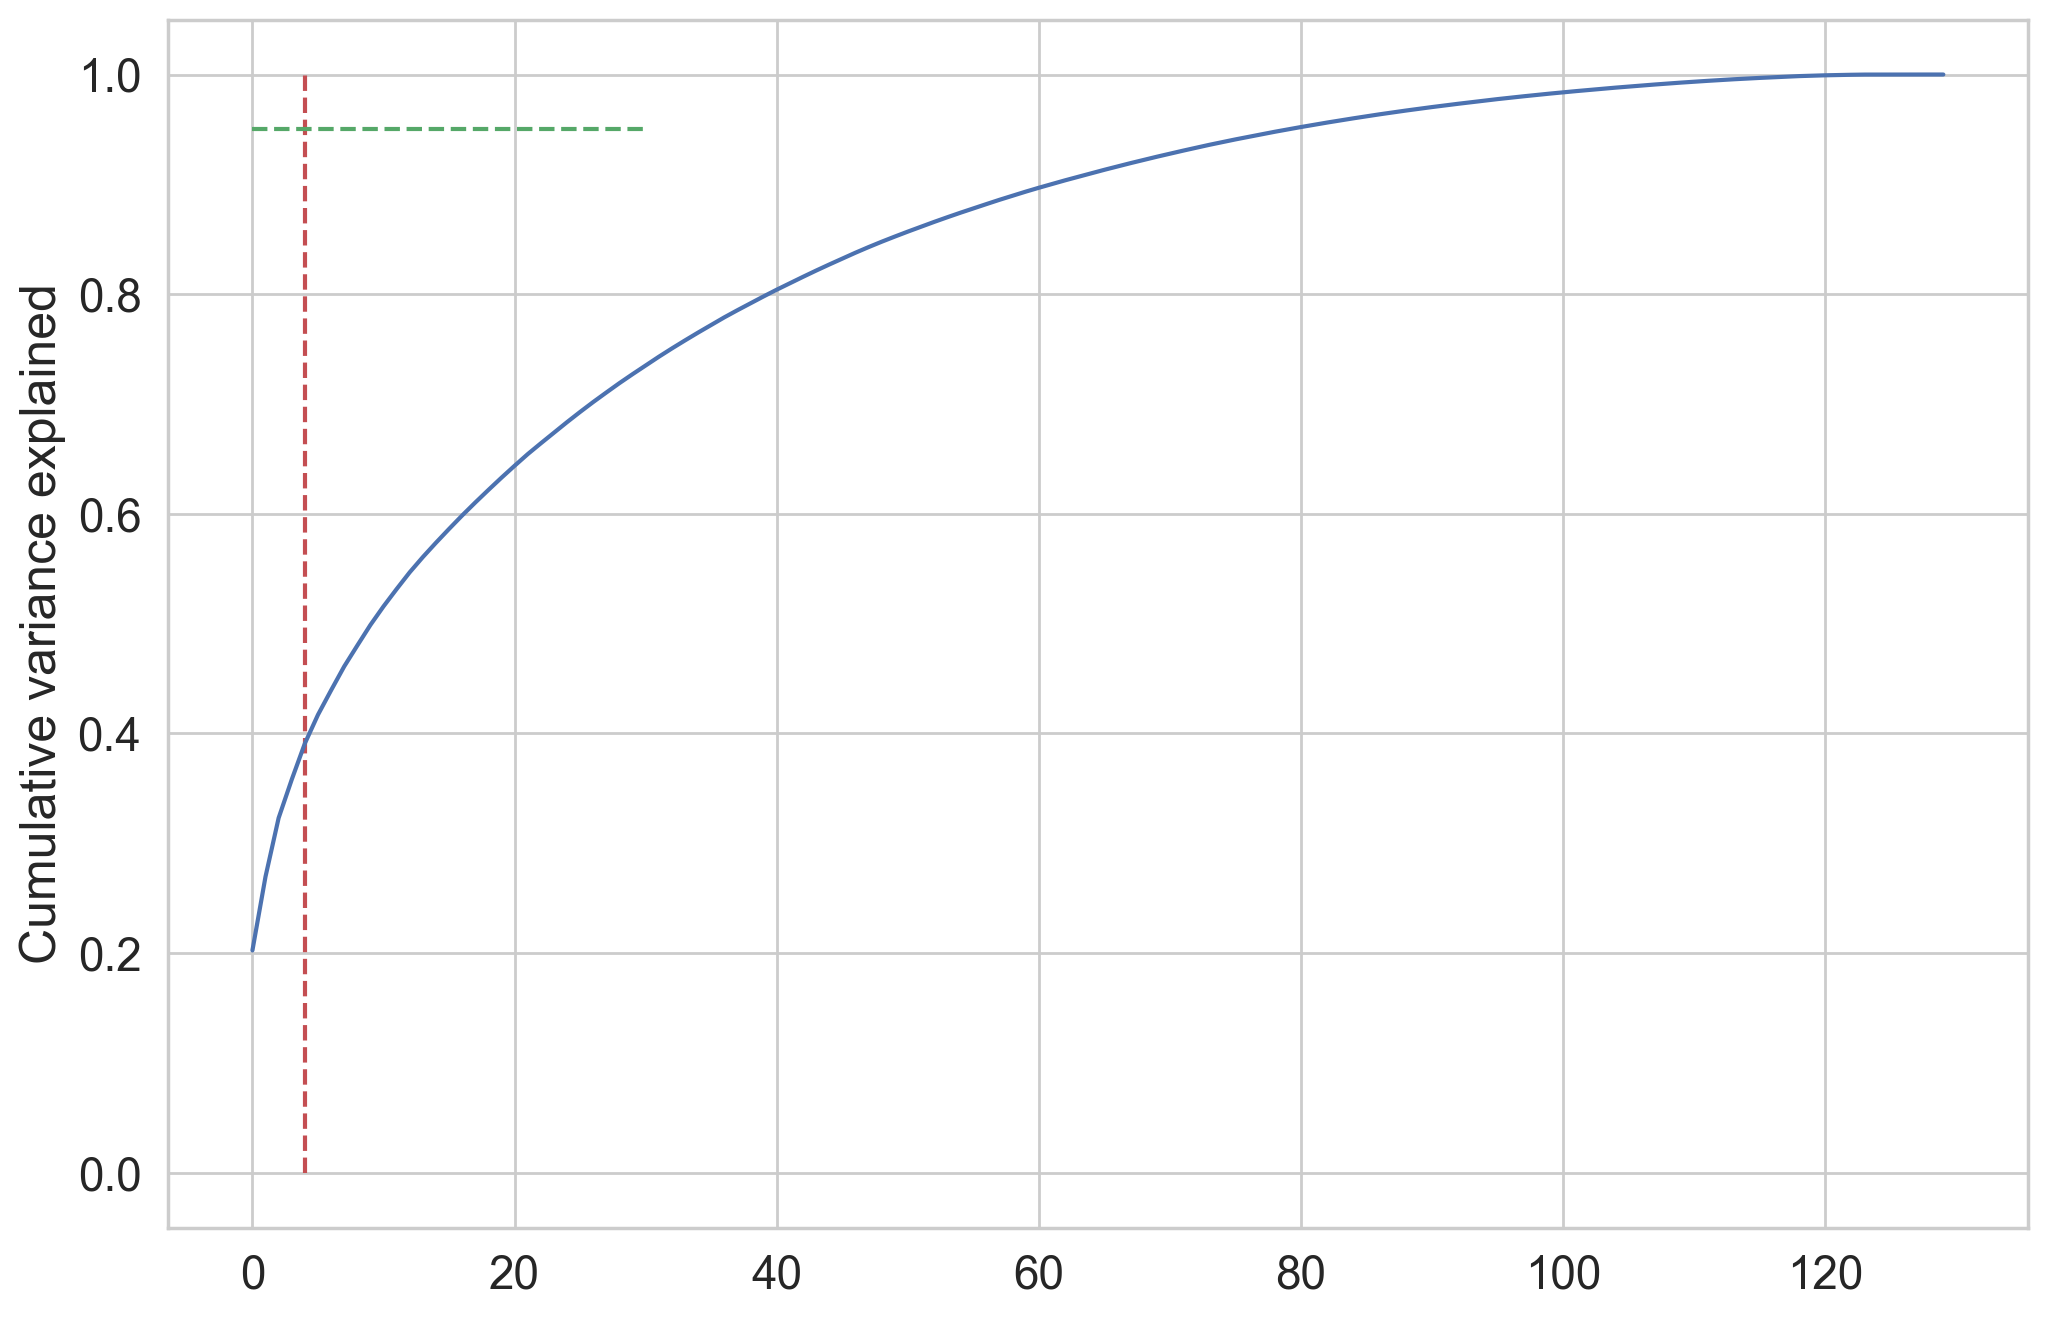

In [46]:
fig = plt.figure(figsize=[12,8],dpi=200)
plt.vlines(x=4, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=30, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

In [47]:
from sklearn.decomposition import IncrementalPCA

In [48]:
pca_final = IncrementalPCA(n_components=3)

In [49]:
X_pca_final = pca_final.fit_transform(X_scaled)

In [50]:
X_pca_final = pd.DataFrame(X_pca_final) 
X_pca_final.columns = ['P1', 'P2','P3'] 

In [51]:
corrmat = np.corrcoef(X_pca_final.transpose())

In [52]:
corrmat.shape

(3, 3)

<AxesSubplot:>

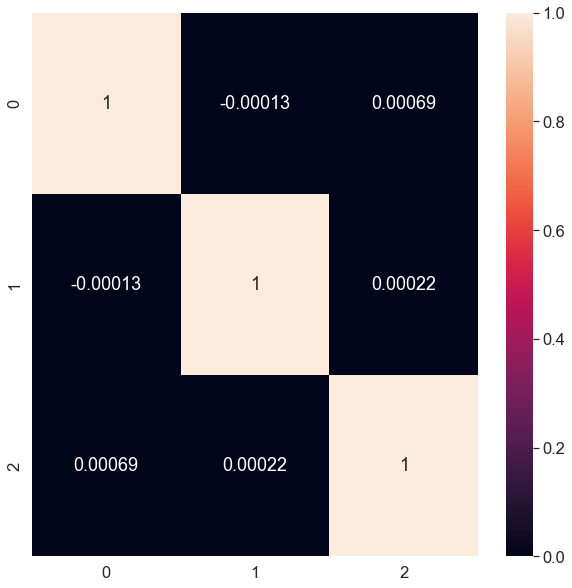

In [53]:
# Plotting the heatmap of the corr matrix
plt.figure(figsize=[10,10])
sns.heatmap(corrmat, annot=True)

In [54]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [55]:
# k-means with some arbitrary k (number of clusters)
kmeans = KMeans(n_clusters=5, max_iter=1000)
kmeans.fit(X_pca_final)

KMeans(max_iter=1000, n_clusters=5)

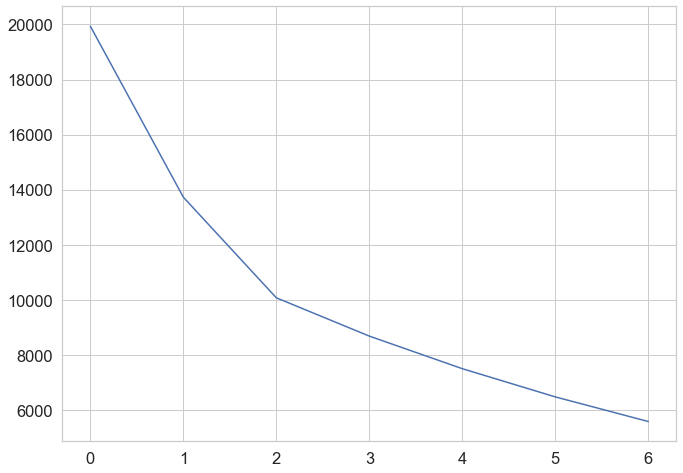

In [56]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000)
    kmeans.fit(X_pca_final)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

In [57]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000)
    kmeans.fit(X_pca_final)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(X_pca_final, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.4903121537210055
For n_clusters=3, the silhouette score is 0.43308961598176504
For n_clusters=4, the silhouette score is 0.4664374433956492
For n_clusters=5, the silhouette score is 0.44016971614411693
For n_clusters=6, the silhouette score is 0.43786855885462883
For n_clusters=7, the silhouette score is 0.36803055468204415
For n_clusters=8, the silhouette score is 0.36862599423294906


In [58]:
# final model with k=4
kmeans = KMeans(n_clusters=4, max_iter=1000, random_state=42)
kmeans.fit(X_pca_final)

KMeans(max_iter=1000, n_clusters=4, random_state=42)

In [59]:
X_pca_final

,P1,P2,P3
0,-8.535823,-1.401225,1.688920
1,-10.176328,-4.045148,3.629910
2,-7.776155,-1.496950,1.839883
3,-9.846235,-3.518579,3.237940
4,-8.739470,-3.418957,3.211064
...,...,...,...
918,0.293646,2.439299,-1.123294
919,1.416378,2.953410,-1.550628
920,0.870088,3.153954,-0.923271
921,-0.476459,2.366432,-0.598781


/Users/vidhisingh/Work/ms_engage/dev/ms-engage-segmently/venv/lib/python3.8/site-packages/matplotlib/collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


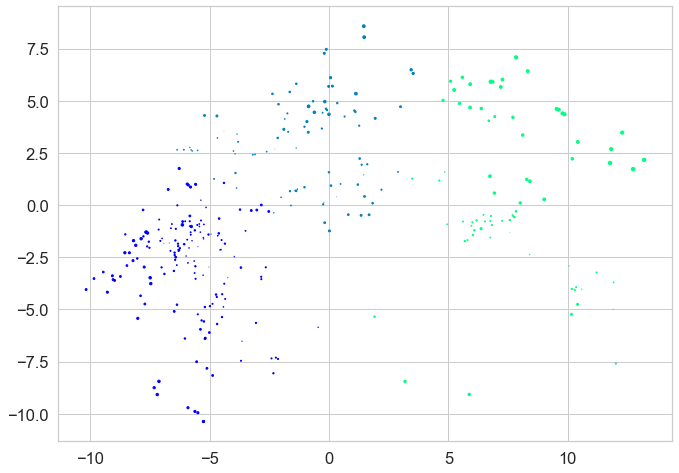

In [60]:
# Visualizing the clustering 
plt.scatter(X_pca_final['P1'], X_pca_final['P2'], X_pca_final['P3'],
           c = KMeans(n_clusters = 3).fit_predict(X_pca_final), cmap =plt.cm.winter) 
plt.show() 

In [65]:
features_df_outliers_removed['K-Means_Cluster_ID'] = kmeans.labels_
features_df_outliers_removed['P1'] = pd.Series(X_pca_final['P1'].values)
features_df_outliers_removed['P2'] = pd.Series(X_pca_final['P2'].values)
features_df_outliers_removed['P3'] = pd.Series(X_pca_final['P3'].values)

/var/folders/s0/w17scwd1277ff63dz232pg940000gp/T/ipykernel_6212/2618127639.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df_outliers_removed['K-Means_Cluster_ID'] = kmeans.labels_
/var/folders/s0/w17scwd1277ff63dz232pg940000gp/T/ipykernel_6212/2618127639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df_outliers_removed['P1'] = pd.Series(X_pca_final['P1'].values)
/var/folders/s0/w17scwd1277ff63dz232pg940000gp/T/ipykernel_6212/2618127639.py:3: SettingWithCopyWarning: 
A value is 

In [66]:
features_df_outliers_removed

,Make,Model,Variant,Displacement,Cylinders,Valves_Per_Cylinder,Drivetrain,Cylinder_Configuration,Emission_Norm,Engine_Location,...,USB_Ports,Heads-Up_Display,Welcome_Lights,Battery,Electric_Range,price,K-Means_Cluster_ID,P1,P2,P3
0,Tata,Nano Genx,Xt,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,0.0,No,No,No,No,292667,2,-8.535823,-1.401225,1.688920
1,Tata,Nano Genx,Xe,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,0.0,No,No,No,No,236447,2,-10.176328,-4.045148,3.629910
3,Tata,Nano Genx,Xta,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,0.0,No,No,No,No,334768,2,-9.846235,-3.518579,3.237940
4,Tata,Nano Genx,Xm,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,0.0,No,No,No,No,272223,2,-8.739470,-3.418957,3.211064
5,Tata,Nano Genx,Xma,624,2,2.0,RWD (Rear Wheel Drive),In-line,BS IV,"Rear, Transverse",...,0.0,No,No,No,No,314815,2,-7.715955,-4.737898,3.401382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271,Honda,City,Vx Mt Diesel,1498,4,4.0,FWD (Front Wheel Drive),In-line,BS IV,"Front, Transverse",...,0.0,No,No,No,No,1302000,0,NaN,NaN,NaN
1272,Honda,City,Zx Mt Diesel,1498,4,4.0,FWD (Front Wheel Drive),In-line,BS IV,"Front, Transverse",...,0.0,No,No,No,No,1421000,0,NaN,NaN,NaN
1273,Honda,City,Zx Cvt Petrol,1497,4,4.0,FWD (Front Wheel Drive),In-line,BS 6,"Front, Transverse",...,0.0,No,No,No,No,1431000,0,NaN,NaN,NaN
1274,Honda,City,V Cvt Petrol,1497,4,4.0,FWD (Front Wheel Drive),In-line,BS 6,"Front, Transverse",...,0.0,No,No,No,No,1201000,0,NaN,NaN,NaN


<AxesSubplot:xlabel='K-Means_Cluster_ID', ylabel='price'>

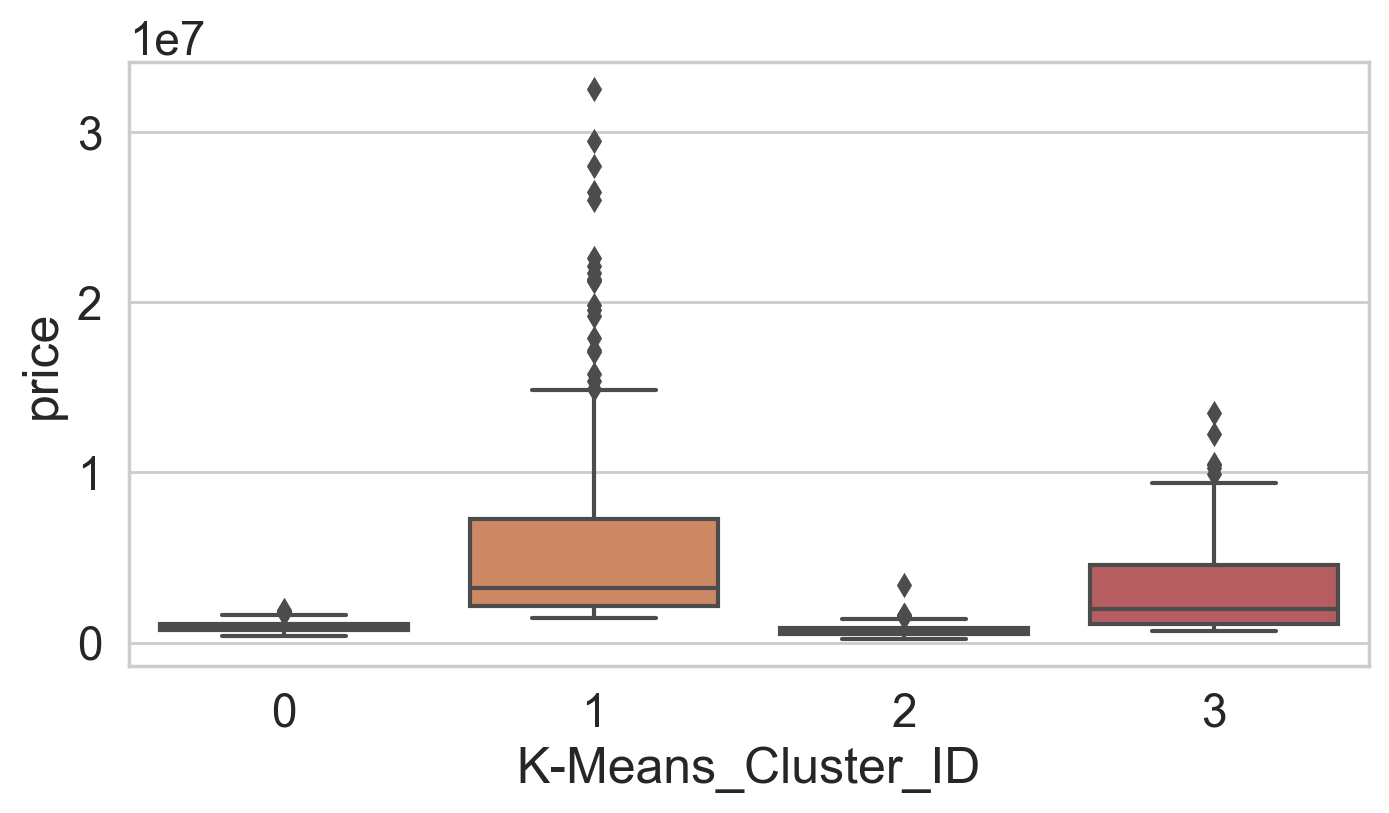

In [63]:
## Price wise cluster comparison
plt.figure(figsize=(8,4),dpi=200)
sns.boxplot(x='K-Means_Cluster_ID', y='price', data=features_df_outliers_removed)